# Assignment 3 - Q3 (SVHN)

In [84]:
import os
import torch
from torch import nn
import torchvision
from torch.autograd import  Variable
from torch import optim
from classify_svhn import get_data_loader

import GAN  # needed to allow the reload
import importlib
importlib.reload(GAN)
from GAN import Generator, Discriminator

import matplotlib.pyplot as plt

lr = 0.0001
betas = (0, 0.9)
batch_size = 64
z_size = 100
im_size = 32
n_critic = 5
num_epoch = 10

if torch.cuda.is_available():
    print("Using cuda")
    device = torch.device("cuda")
else:
    print("Running on cpu")
    device = torch.device("cpu")
    
G = Generator(z_size).to(device)
D = Discriminator(im_size, device).to(device)

g_optim = optim.Adam(G.parameters(), lr=lr, betas=betas)
d_optim = optim.Adam(D.parameters(), lr=lr, betas=betas)

Using cuda


In [79]:
import vae
importlib.reload(vae)
from vae import VAE

vae_model = VAE(type='SVHN').to(device)
vae_optim = optim.Adam(vae_model.parameters(), lr=lr, betas=betas)

## Data

In [67]:
def showImg(x):
    x = x.permute(1, 2, 0)
    plt.imshow((x.numpy() * 0.5) + 0.5)

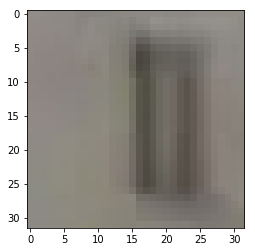

In [3]:
train_loader, valid_loader, test_loader = get_data_loader("svhn", batch_size)

# Show an image
real_sample, target = next(iter(train_loader))

showImg(real_sample[0])

In [ ]:
def train(loader):
    d_train_loss = 0
    
    for epoch in range(num_epoch):
        
        for data_idx, real_sample in enumerate(loader):
            G.train()
            D.train()
            
            step = epoch * len(loader) + data_idx + 1
            
            # Train more the dicriminator
            d_optim.zero_grad()
            g_optim.zero_grad()
    
            z = Variable(torch.randn(batch_size, z_size, device=device))
            
            fake_sample = G(z)
            real_sample = real_sample.to(device)
            
            d_loss = D.loss(real_sample, fake_sample)
            d_loss.backward()
            d_optim.step()
    
            if step % n_critic == 0:
                # Train the generator
                d_optim.zero_grad()
                g_optim.zero_grad()
            
                z = Variable(torch.randn(batch_size, z_size, device=device))
            
                fake_sample = G(z)
                fake_result = D(fake_sample)
                g_loss = G.loss(fake_result)
                g_loss.backward()
                g_optim.step()
                
        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, d_train_loss / len(loader.dataset)))
        
        createSample(G)

In [ ]:
def createSample(generator):
    generator.eval()
    
    z = Variable(torch.randn(z_size, device=device))
    im = generator(z)
    showImg(im)

In [ ]:
train(train_loader)

## VAE training

In [90]:
def saveImg(x, name):
    save_dir = 'sample/'
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    torchvision.utils.save_image(x, save_dir+name)

    
def generateImageWithVAE(model, name):
    model.eval()
    z = Variable(torch.randn(3, z_size, device=device))
    x, _, _ = model.decode(z)
    x = x * 0.5 + 0.5
    saveImg(x, name)
    x = x.permute(1, 2, 0)
    plt.imshow(x.cpu().detach().numpy())

In [94]:
def ELBO_loss_function(recon_x, x, mu, logvar):
    # ELBO: L(θ, φ; x) = -E_z~q_φ[log p_θ(x|z)] + D_KL(q_φ(z|x)||p(z))
    # reconstruction loss + regularizer (forcing the encoder's output to stay close to a standard Normal distribution)
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    batch_size = x.shape[0]
    
    return (MSE + KLD) / batch_size


def train_vae(model, num_epoch, train_loader, optimizer):
    for epoch in range(num_epoch):
        model.train()
        train_loss = 0
        for batch_idx, (data, y) in enumerate(train_loader):
            data = data.to(device)
            flattened_data = data.view(-1, 3072)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(flattened_data)
            loss = ELBO_loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader)))
        
        # generateImageWithVAE(model, f"vae_svhn_epoch_{epoch}.jpg")

In [95]:
train_vae(vae_model, num_epoch, train_loader, vae_optim)

Train Epoch: 0 [0/65931 (0%)]	Loss: 116.805061
Train Epoch: 0 [6400/65931 (10%)]	Loss: 116.249420
Train Epoch: 0 [12800/65931 (19%)]	Loss: 93.955841
Train Epoch: 0 [19200/65931 (29%)]	Loss: 115.484207
Train Epoch: 0 [25600/65931 (39%)]	Loss: 104.638992
Train Epoch: 0 [32000/65931 (48%)]	Loss: 107.464859
Train Epoch: 0 [38400/65931 (58%)]	Loss: 110.362564
Train Epoch: 0 [44800/65931 (68%)]	Loss: 107.487091
Train Epoch: 0 [51200/65931 (78%)]	Loss: 99.528549
Train Epoch: 0 [57600/65931 (87%)]	Loss: 103.119507
Train Epoch: 0 [64000/65931 (97%)]	Loss: 96.123711
====> Epoch: 0 Average loss: 104.1066
Train Epoch: 1 [0/65931 (0%)]	Loss: 88.566765
Train Epoch: 1 [6400/65931 (10%)]	Loss: 100.086136
Train Epoch: 1 [12800/65931 (19%)]	Loss: 120.026741
Train Epoch: 1 [19200/65931 (29%)]	Loss: 94.441765
Train Epoch: 1 [25600/65931 (39%)]	Loss: 106.177162
Train Epoch: 1 [32000/65931 (48%)]	Loss: 120.037155
Train Epoch: 1 [38400/65931 (58%)]	Loss: 108.629448
Train Epoch: 1 [44800/65931 (68%)]	Loss: 90

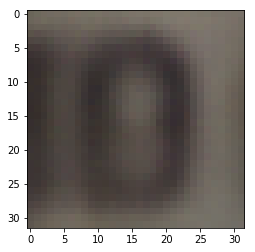

In [96]:
for i in range(10):
    generateImageWithVAE(vae_model, f"vae_svhn_30epochs_{i}.jpg")